### DEiT: Data Efficient Image Transformer

In [21]:
import os
from PIL import Image
import time
import torch
from torchvision import transforms
from transformers import get_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import timm
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

#### Dataset

In [2]:
class FoldDataset(Dataset):
    def __init__(self, root_dir, section, transform=None):
        self.root_dir = root_dir
        self.section = section
        self.transform = transform
        self.samples = []

        for fold in os.listdir(self.root_dir):
            section_path = os.path.join(self.root_dir, fold, self.section)
            for label in ['normal', 'abnormal']:
                label_path = os.path.join(section_path, label)
                if os.path.exists(label_path):
                    for img in os.listdir(label_path):
                        self.samples.append((os.path.join(label_path, img), 0 if label == 'normal' else 1))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
print(torch.cuda.is_available())

True


#### Model Setup

In [5]:
# Model setup
print("Loading DeiT...")
model = timm.create_model('deit_base_distilled_patch16_224', pretrained=True, num_classes=2)
device = torch.device('cuda')
model.to(device)

Loading DeiT...


VisionTransformerDistilled(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
       

#### Optimizer

In [6]:
# Optimizer setup
print("Setting up optimizer...")
optimizer = AdamW(model.parameters(), lr=4e-5)

Setting up optimizer...


#### Dataloader

In [7]:
base_dir = './data'

# DataLoader setup
print("Preparing data loaders...")
train_dataset = FoldDataset(root_dir=base_dir, section='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = FoldDataset(root_dir=base_dir, section='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Preparing data loaders...


#### Loss Function

In [8]:
# Loss function
loss_fn = CrossEntropyLoss()

#### Learning Rate Scheduler

In [9]:
# Scheduler setup
print("Configuring scheduler...")
num_training_steps = len(train_loader) * 15  # 15 epochs
num_warmup_steps = int(0.08 * num_training_steps)  # 8% of total steps as warmup
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

Configuring scheduler...


#### Training

In [10]:
# Training loop
def train_one_epoch(model, data_loader, optimizer, loss_fn, scheduler, device):
    model.train()
    total_loss = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

In [11]:
# Validation loop
def validate(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return total_loss / len(data_loader), accuracy

In [13]:
# Training and Validation Execution
train_losses = []
val_losses = []
val_accuracies = []
training_time = 0
print("Starting training and validation...")
for epoch in range(15):
    start_time = time.time()
    print(f"Epoch {epoch+1}/{15}")
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, scheduler, device)
    val_loss, val_accuracy = validate(model, val_loader, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    end_time = time.time()
    epoch_time = end_time - start_time
    training_time += epoch_time
    print(f'Train Loss: {train_loss}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, Time Taken: {epoch_time:.2f} seconds')
print("Total training time = ", training_time)

Starting training and validation...
Epoch 1/15
Train Loss: 0.197124246803254, Val Loss: 0.12192838841495163, Val Accuracy: 0.9670634920634921, Time Taken: 800.62 seconds
Epoch 2/15
Train Loss: 0.023166065237392192, Val Loss: 0.17433911103580613, Val Accuracy: 0.9682539682539683, Time Taken: 798.70 seconds
Epoch 3/15
Train Loss: 0.005501038950831595, Val Loss: 0.11171032775350392, Val Accuracy: 0.9793650793650793, Time Taken: 798.44 seconds
Epoch 4/15
Train Loss: 0.00014085716286643625, Val Loss: 0.12236565412691745, Val Accuracy: 0.9777777777777777, Time Taken: 798.71 seconds
Epoch 5/15
Train Loss: 4.475553202660209e-05, Val Loss: 0.12739225971809798, Val Accuracy: 0.9785714285714285, Time Taken: 798.59 seconds
Epoch 6/15
Train Loss: 2.945213242263769e-05, Val Loss: 0.13190181003428042, Val Accuracy: 0.9785714285714285, Time Taken: 798.93 seconds
Epoch 7/15
Train Loss: 2.165606337136809e-05, Val Loss: 0.13527843391842262, Val Accuracy: 0.9793650793650793, Time Taken: 799.16 seconds
Epo

#### Saving the model

In [14]:
# Save the model
torch.save(model.state_dict(), "models/trained_deit_model.pth")

#### Plots

Plotting the losses...


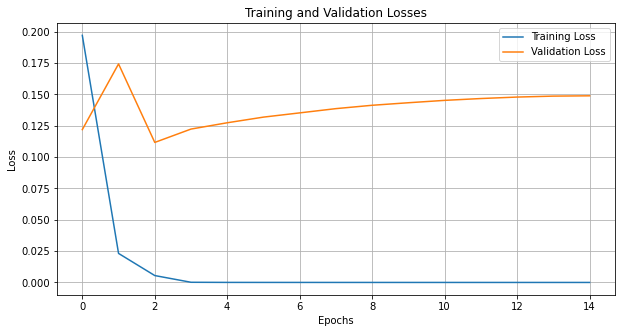

In [15]:
# Plotting the training and validation losses
print("Plotting the losses...")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

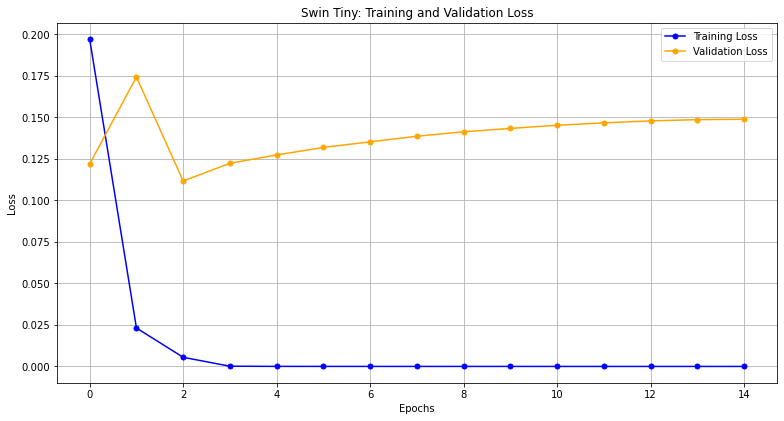

In [16]:
fig = plt.figure(figsize=(10,5)) # make plot
axis = fig.add_axes([0,0,1,1])
axis.plot(train_losses, color='blue', marker='o', ms=5)
axis.plot(val_losses, color='orange', marker='o', ms=5)
axis.set_ylabel("Loss")
axis.set_xlabel("Epochs")

axis.set_title("Swin Tiny: Training and Validation Loss")
axis.grid()

axis.legend(["Training Loss", "Validation Loss"])
plt.show()

In [17]:
# Function to evaluate the model on the validation or test set
def evaluate(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

# Evaluate the model on the validation set
y_true_val, y_pred_val = evaluate(model, val_loader, device)

In [18]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_true_val, y_pred_val)
precision = precision_score(y_true_val, y_pred_val)
recall = recall_score(y_true_val, y_pred_val)
f1 = f1_score(y_true_val, y_pred_val)

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Validation Accuracy: 0.9794
Precision: 0.9928
Recall: 0.9614
F1 Score: 0.9768


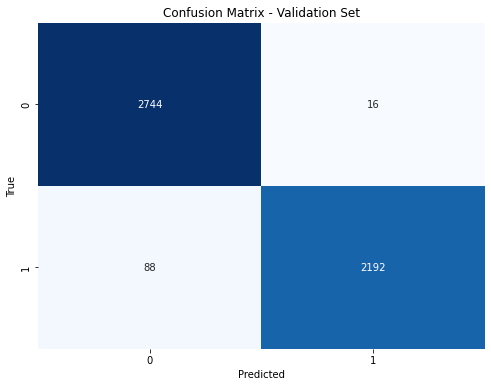

In [19]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_val, y_pred_val)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation Set')
plt.show()

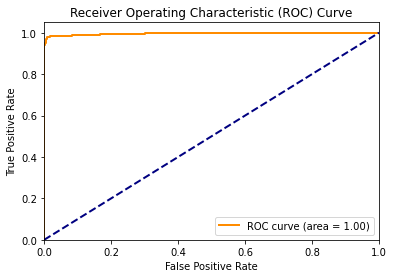

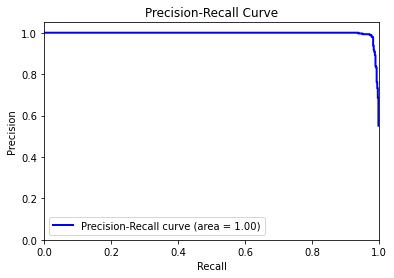

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
# Function to plot ROC AUC curve
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Function to get predicted probabilities
def predict_probabilities(model, data_loader, device):
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())
    return y_true, y_scores

# Get true labels and predicted probabilities
y_true_val, y_scores_val = predict_probabilities(model, val_loader, device)

# Extract probabilities for the positive class
y_scores_positive = [score[1] for score in y_scores_val]

# Plot ROC AUC curve
plot_roc_curve(y_true_val, y_scores_positive)

# Plot Precision-Recall curve
plot_precision_recall_curve(y_true_val, y_scores_positive)